pure tabular learning

In [1]:
#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from UCLSE.dyna_q.Experiment4 import Experiment,Dyna_QAgentTabular
from UCLSE.dyna_q.dyna_q import TabularMemory
import numpy as np
import pandas as pd
import visdom

In [3]:
name='Experiment4'

In [4]:
vis=visdom.Visdom(port=8097)

In [5]:
def reward_oracle(observation,cutoff=50,ub=6,lb=-2,lamb=0.5):


    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    bid_change=observation.bid_change
    bid_ask_spread=observation.bid_ask_spread
    time_left=observation.time_left

    ans=lamb*bid_change

    if inventory==0:   #terminal            
            
            ans+=-(1-lamb)*distance
            ans-=lamb*bid_change

    elif inventory>1: #terminal
            
            ans+=-bid_ask_spread*(inventory-1)
            ans+=-(1-lamb)*distance
           
    else:

            if orders_out>0: 
                ans+=1/250


            if time_left==1: #terminal takes account of exit spread
               
                ans+=-(1-lamb)*distance

            if -distance>=ub:
                
                ans+=-(1-lamb)*distance
              

            elif -distance<lb:
               
                ans+=-(1-lamb)*distance
               

    return ans 

def done_oracle(observation,cutoff=50,lb=-2,ub=6):

    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    time_left=observation.time_left

    if inventory==0:
        done=1
        why=f'inventory {inventory}=0'
    elif time_left>=1:
        done=1
        why=f'time up {time_left}'
    elif inventory>1:
        done=1
        why=f'inventory {inventory}>1'
    elif -distance>=ub:
        done=1
        why=f'-distance {distance} >ub {ub}'
    elif -distance<lb: 
        done=1
        why=f'-distance {distance}<lb {lb}'

    else:
        done=0 
        why=None
    return done,why

In [6]:
trader_pref_kwargs={'qty_min':-5,'qty_max':5,'sigma_pv':1}
timer_kwargs={'start':0,'end':5000,'step':1}
price_sequence_kwargs={'kappa':0.0002,'mean':100,'sigma':1,'block_length':10}
noise_kwargs={'sigma':1}
messenger_kwargs={'logging':True}
env_kwargs={'trader_arrival_rate':1,'recording':True,#'process_verbose':False,
                'bookkeep_verbose':False, 'lob_verbose':False}
sigma_n=5

def cont_coef():
    return np.random.uniform(0.2,0.8)

def personal_memory():
    return int(np.random.uniform(5,15))

trader_kwargs={'ZIP':{'prefix':'ZIP','number':10,'object_name':'WW_Zip',
                          'setup_kwargs':
                                {'market_make':True,'prior':(100,sigma_n)}},
               'HBL':{'prefix':'HBL','number':10,'object_name':'HBL',
                          'setup_kwargs':
                              {'memory':100,'grace_period':20}},
               'CON':{'prefix':'CON','number':10,'object_name':'ContTrader',
                      'setup_kwargs':
                          {'cont_coeff':cont_coef,'personal_memory':personal_memory,'profit_target':4, 'market_make':True,
                          'prior':(100,sigma_n)}},
               'NOI':{'prefix':'NOI','number':10,'object_name':'NoiseTrader',
                          'setup_kwargs':{'memory':20}}
              }

lobenv_kwargs={'cutoff':100,'profit_target':10,'loss_limit':-2,'reward_func':reward_oracle,'lamb':0.5}


exploration ={"mode":'Greedy',
        "type": "exponential",
        "init_epsilon": 0.8,
        "min_epsilon": 0.01,
        "decay_steps": 100000,
        "decay_eps": 0.99,
        "choice":'least_bonus'}

agent_kwargs={'n_actions':5,'initial_Q':1,'init_epsilon':0.8,'exploration':exploration,
             'memory_capacity':1000000,'n_statespace':9,'discount':0.99}



experiment=Experiment(trader_pref_kwargs,timer_kwargs,
           price_sequence_kwargs,noise_kwargs,
           messenger_kwargs,env_kwargs,trader_kwargs,
           lobenv_kwargs,agent_kwargs=agent_kwargs,visdom=vis,agent=Dyna_QAgentTabular,name=name)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL


In [7]:
experiment.new_train_setup(planning_steps=1,planning=True,graph=True,MaxEpisodes=1000)

In [9]:
experiment.train(MaxEpisodes=1001,folder='Results/'+experiment.name,start_episode=experiment.episode)

Exploration is Greedy
Dyna-Q - EXP: 1 | Ep: 21 | timestep: 5 | Ep_r:  0.008 Profit: -1 Avg loss:-0.03828571428571428 |  Time to backup 0
Dyna-Q - EXP: 1 | Ep: 41 | timestep: 10 | Ep_r:  0.032 Profit: -1 Avg loss:-0.039219512195121944 |  Time to backup 0


KeyboardInterrupt: 

In [8]:
Experiment.resume(exp=experiment,best=True,folder='Results/'+experiment.name)

=> loading checkpoint 'Results/Experiment4\dyna_best.pth.tar'
=> loaded checkpoint 'Results/Experiment4\dyna_best.pth.tar' (epoch 919)
keys unused in checkpoint data:  ['episode', 'learn_step_counter', 'setup']


In [9]:
experiment.test_setup(MaxEpisodes=50,agent=experiment.agent)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1, | timestep:  14 | Ep_r: -1.9422410375044021|profit:-3 start:226|end:240
Dyna-Q - EXP 1, | Ep: , 26, | timestep:  7 | Ep_r: -0.9745624597604|profit:-2 start:3658|end:3665
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL


In [10]:
experiment.agent_test.tabular

state counter length: 339, state_action counter length: 365, total experiences: 3798

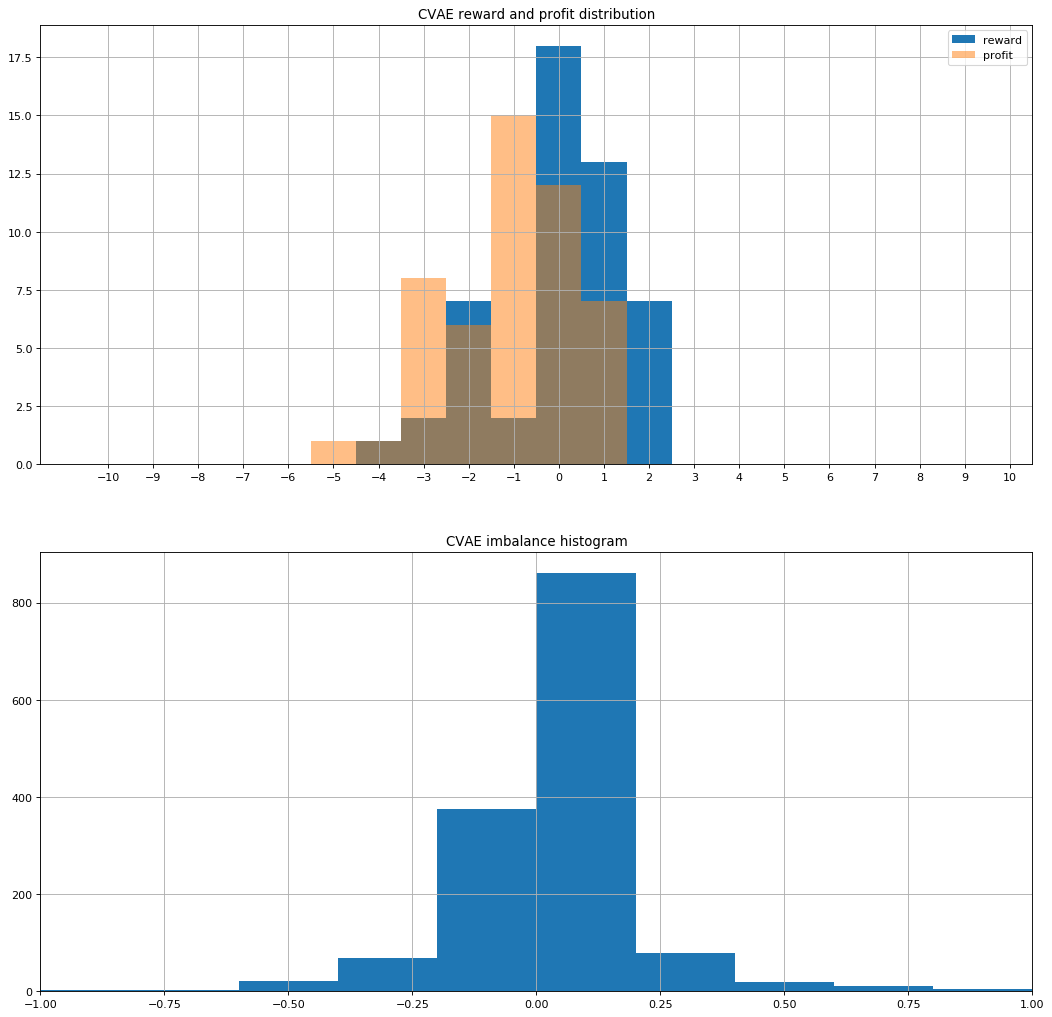

In [11]:
path='Results'
d,memory=experiment.plotbm_results(experiment,'CVAE reward and profit distribution',
                                   'CVAE imbalance histogram',name=experiment.name,path=path)

In [12]:
returns,memory=experiment.memory_returns_loader(experiment)

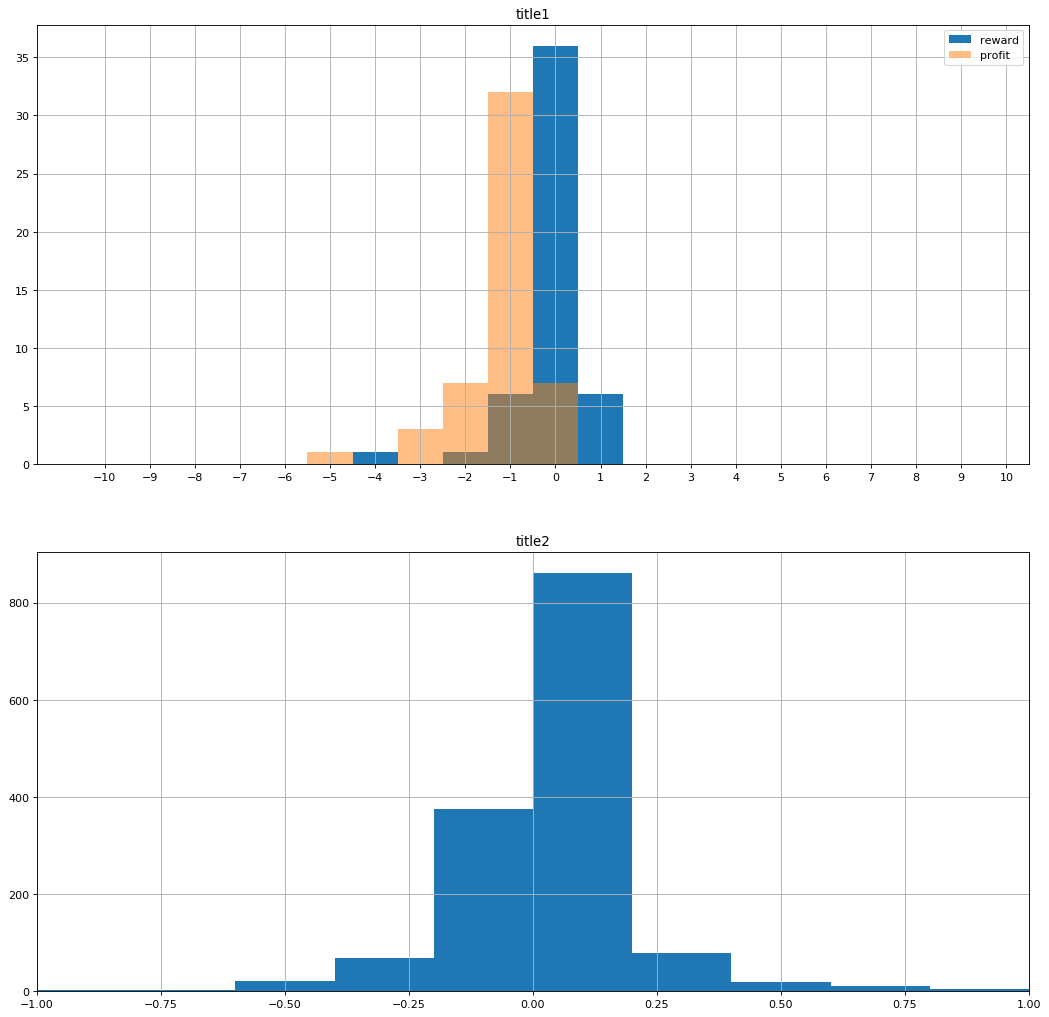

In [13]:
returns,memory=experiment.plotbm_results(experiment,'title1','title2',returns,memory,'messing')

In [14]:
clf,train_score,test_score,importances=experiment.fit_tree(memory,os.path.join('Results',experiment.name),experiment)

In [ ]:
train_score,test_score

In [18]:
importances['test_score']=test_score
importances['train_score']=train_score
importances

,obs_name,importance,test_score
0,distance,0.277411,0.33
1,inventory,0.000000,0.33
2,orders_out,0.000000,0.33
3,bid_change,0.000000,0.33
4,ask_change,0.000000,0.33
5,bid_ask_spread,0.358244,0.33
6,position_in_lob,0.000000,0.33
7,imbalance,0.364345,0.33
8,time_left,0.000000,0.33
